In [1]:
# libraries for data exploration.
import pandas as pd
import numpy as np

# library for splitting data.
from sklearn.model_selection import train_test_split

# libraries for preparing the data.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# libraries for building linear models.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# library for measuring error. 
from sklearn.metrics import mean_squared_error

# user defined.
from helpful_functions import MLFunctions

In [3]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    index_col='date',
                    parse_dates=['date'])

In [4]:
# use MLfunction class to convert date to equivalent dummy time.
user_function = MLFunctions(sales)
date_num = user_function.dateNum()

In [5]:
# create new column with numeric values equivalent to dates. 
sales["date_num"] = date_num

In [7]:
sales = sales.sort_values(by="date_num")

In [9]:
sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_num
date,,,,,,
02.01.2013,0,59,22154,999.0,1.0,0
02.01.2013,0,56,14870,299.0,1.0,0
02.01.2013,0,56,14886,849.5,1.0,0
02.01.2013,0,29,5378,2990.0,1.0,0
02.01.2013,0,41,17560,318.6,1.0,0


In [13]:
# split sales into train and test sets. 
train_set, test_set = train_test_split(sales, test_size=0.2, random_state=44)

In [15]:
# training and test data created.
X_train = train_set.loc[:, ["date_block_num", "shop_id", "item_id", "item_price", "date_num"]]
y_train = train_set["item_cnt_day"]
X_test = test_set.loc[:, ["date_block_num", "shop_id", "item_id", "item_price", "date_num"]]
y_test = test_set["item_cnt_day"]

In [7]:
# adds additional features to fit the nonlinear data.
poly_feat = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly_feat.fit_transform(X_train)
X_test_poly = poly_feat.fit_transform(X_test)

In [17]:
# ensures that columns have same scale.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [19]:
# linear regression without polynomial features.
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [35]:
# measures training error.
sales_predictions_train = lin_reg.predict(X_train_scaled)
lin_mse = mean_squared_error(sales_predictions_train, y_train)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.7302882478062793

C:\Users\Admin\AppData\Local\Temp\ipykernel_12512\1753243161.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


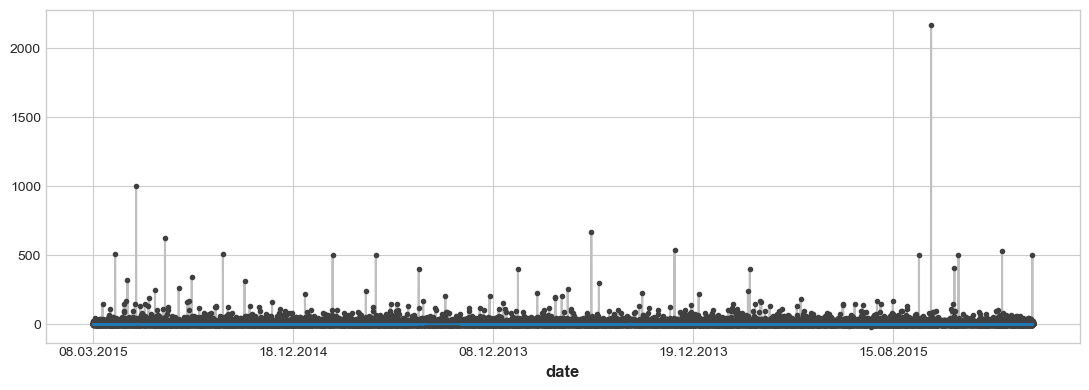

In [51]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
ax = y_train.plot(**plot_params)
ax = pd.Series(sales_predictions_train, index=X_train.index).plot(ax=ax)

In [17]:
# measures test error.
sales_predictions_test = lin_reg.predict(X_test)
lin_mse = mean_squared_error(sales_predictions_test, y_test)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.159645088273082

In [12]:
sgd_reg = SGDRegressor(max_iter=10000, tol=1e-10, penalty=None, eta0=1e-100)
sgd_reg.fit(X_train_scaled, y_train)

SGDRegressor(eta0=1e-100, max_iter=10000, penalty=None, tol=1e-10)

In [13]:
# measures training error.
sales_predictions_train = sgd_reg.predict(X_train_scaled)
sgd_mse = mean_squared_error(sales_predictions_train, y_train)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

2.9902927476979446

In [14]:
# measures test error.
sales_predictions_test = sgd_reg.predict(X_test_scaled)
sgd_mse = mean_squared_error(sales_predictions_test, y_test)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

2.4989672066652013

In [72]:
# regularized linear model. 
ridge_reg = Ridge(alpha=1, solver="sparse_cg")
ridge_reg.fit(X_train_scaled, y_train)

Ridge(alpha=1, solver='sparse_cg')

In [73]:
# measures training error.
sales_predictions_train = ridge_reg.predict(X_train_scaled)
grid_mse = mean_squared_error(sales_predictions_train, y_train)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.7135467950599668

In [74]:
# measures test error.
sales_predictions_test = ridge_reg.predict(X_test_scaled)
grid_mse = mean_squared_error(sales_predictions_test, y_test)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.1616129585139467

In [18]:
# regularized linear model.
# unnecessary features are dropped.
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [19]:
# measures training error.
sales_predictions_train = lasso_reg.predict(X_train_scaled)
grid_mse = mean_squared_error(sales_predictions_train, y_train)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.7197873194636992

In [20]:
# measures test error.
sales_predictions_test = lasso_reg.predict(X_test_scaled)
grid_mse = mean_squared_error(sales_predictions_test, y_test)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.168521623644962

In [21]:
# regularized linear model.
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.1)

In [22]:
# measures training error.
sales_predictions_train = elastic_net.predict(X_train_scaled)
grid_mse = mean_squared_error(sales_predictions_train, y_train)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.7190832692452838

In [23]:
# measures test error.
sales_predictions_test = elastic_net.predict(X_test_scaled)
grid_mse = mean_squared_error(sales_predictions_test, y_test)
grid_rmse = np.sqrt(grid_mse)
grid_rmse

2.1676270527193062